In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import sys
from sklearn.preprocessing import MinMaxScaler
from glob import glob
ROOT_DIR = "../"
sys.path.append(ROOT_DIR)
import matplotlib.pyplot as plt
import seaborn as sns
from utils.citymeta import load_all
import h3
# city_meta = load_all()
plt.rcParams["figure.figsize"] = [3, 4]
plt.rcParams["figure.autolayout"] = True
plt.rcParams['svg.fonttype'] = 'none'


# Visualize the distribution of clusters per city

In [2]:
import gc
gc.collect()

0

In [ ]:
# ROOT = "/Users/yuan/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was"
ROOT= "D:/Dropbox (Personal)/Personal Work/_Projects2023/01_city-never-was"
# ROOT = "/lustre1/g/geog_pyloo/05_timemachine"
DATAROOT = f"{ROOT}/_data"
TABLE_FOLDER = f"{ROOT}/_table"
# ROOT = "D:/Dropbox (Personal)/Personal Work/_Projects2023"
CURATED_FOLDER = f"{ROOT}/_data/_curated"

EXPORT_FOLDER = f"{CURATED_FOLDER}/c_analysis"
DATA_FOLDER = f"{CURATED_FOLDER}/c_seg_hex"
N = 7
N_CAT = 27
prefixfull = "_built_environment"
# COMMENT = "_no_exposure_constrain"
COMMENT = ""
# CITY_LEVEL_FILE = f"c_city{prefixfull}_full_cluster={N}_ncat={N_CAT}.csv"
CITY_LEVEL_FILE = f"c_city{prefixfull}_full_cluster={N}_ncat={N_CAT}{COMMENT}.csv"

HEX_LEVEL_FILE = f"c_hex{prefixfull}_full_cluster={N}_ncat={N_CAT}{COMMENT}.csv"

city_df = pd.read_csv(os.path.join(EXPORT_FOLDER, CITY_LEVEL_FILE))
hex_df = pd.read_csv(os.path.join(EXPORT_FOLDER, HEX_LEVEL_FILE))

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_30336\152033703.py:22: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  hex_df = pd.read_csv(os.path.join(EXPORT_FOLDER, HEX_LEVEL_FILE))


In [4]:
# only use thi when in local machine
GRAPHIC_PATH = f"{ROOT}/_graphic/cluster_figure"
if not os.path.exists(GRAPHIC_PATH):
    os.makedirs(GRAPHIC_PATH)

In [ ]:
target_ls = [
    'num_person_killed_per_lakh_city',
    'num_person_killed_per_lakh_country',
    'cardiovascular_diseases_cap',
    'diabetes_mellitus_cap', 
    'mental_and_substance_use_disorders_cap',
             ]
# plot barplot by each city_group
label_cols = {
    "gdp_per_cap_country_2022":"GDP Country-level",
    "num_person_killed_per_lakh_city":"No. Person Killed Per Lakh",
    "mean_flux":"CO2 Flux"
}
color_schema = {
    # with constrain
    3:"#f15c17", # orange red
    0:"#da70bf", # light pink
    5:"#223f9a", # dark blue
    2:"#ff991f", # orange
    6:"#ff991f", 
    1:"#12939a", # dark green
    4:"#ddb27c", # brown
                }



cluster_name = {
6:"Scenic View",
2:"Scenic View",
3:"Suburban Fringe",
0:"Open Arterials",
5:"Low-rise Community",
1:"High-rise Community",
4:"Dense Road Core",

} # need to find some example images to check the results


In [8]:
hex_df_summary = hex_df.groupby(f'cluster_{N}').size().reset_index().rename(columns = {0: "hex_count"})
hex_df_summary['cluster_name'] = hex_df_summary[f'cluster_{N}'].apply(lambda x:cluster_name[x])
hex_df_summary

,cluster_7,hex_count,cluster_name
0,0,49277,Open Arterials
1,1,48532,High-rise Community
2,2,49576,Scenic View
3,3,57892,Suburban Fringe
4,4,47727,Dense Road Core
5,5,51342,Low-rise Community
6,6,51287,Scenic View


In [216]:
# hex_df_summary.to_csv(os.path.join(TABLE_FOLDER, f"hex_cluster_cluster={N}_ncat={N_CAT}.csv"), index = False
#                       )

In [9]:
# create ranking of target

def generate_summary(target):
    city_df[f'rank_{target}'] = city_df[target].rank(ascending=False)
    city_df[f'rank_{target}'] = city_df[f'rank_{target}'].astype(int)
    # city_df.sort_values(f'rank_{target}')[[f'rank_{target}', target, 'city_lower']]
    # create quintile of the target
    city_df[f'quintile_{target}'] = pd.qcut(city_df[target], 10, labels=False)
    city_df[f'quintile_{target}'] = city_df[f'quintile_{target}'].astype(int)
    city_df.sort_values(f'rank_{target}')[[f'quintile_{target}', target, 'city_lower']]
    clustervari = [f'cluster_{i}' for i in range(N)]
    city_df_summary = city_df[[f'quintile_{target}','city_lower']+clustervari].groupby(f'quintile_{target}')\
            .mean()
    return city_df_summary


In [10]:

# cluster_column_order_num = cluster_name.keys()

# cluster_order = [v for k,v in cluster_name.items()]
# cluster_column_dict_rev = {v:k for k,v in cluster_name.items()}
# city_df_summary = city_df_summary[cluster_column_order]
cluster_order = cluster_name.keys()
cluster_column_order = [f'cluster_{i}' for i in cluster_order]
print(cluster_column_order)
# cluster_column_order_num = [cluster_column_dict_rev[i] for i in cluster_order]
# cluster_column_order_num

['cluster_6', 'cluster_2', 'cluster_3', 'cluster_0', 'cluster_5', 'cluster_1', 'cluster_4']


In [22]:
color_schema_update = {k:color_schema[v] for k,v in zip(cluster_column_order, cluster_order)}
color_schema_update

{'cluster_6': '#ff991f',
 'cluster_2': '#ff991f',
 'cluster_3': '#f15c17',
 'cluster_0': '#da70bf',
 'cluster_5': '#223f9a',
 'cluster_1': '#12939a',
 'cluster_4': '#ddb27c'}

In [23]:
# plot a stacked horizontal barchart to show the distribution of cluster in each quintile
import matplotlib.pyplot as plt
import seaborn as sns

target = 'num_person_killed_per_lakh_city'
# target = 'gdp_per_cap_country_2022'
# target = 'mean_flux'
city_df_summary = generate_summary(target)

# fig, ax = plt.subplots(figsize=(8,3))
city_df_summary[cluster_column_order]

,cluster_6,cluster_2,cluster_3,cluster_0,cluster_5,cluster_1,cluster_4
quintile_num_person_killed_per_lakh_city,,,,,,,
0,0.082691,0.122517,0.224221,0.089892,0.185593,0.110898,0.184189
1,0.092578,0.097874,0.204560,0.102461,0.119548,0.212757,0.170222
2,0.037430,0.077753,0.139715,0.169942,0.203387,0.138113,0.233661
3,0.127271,0.126617,0.144226,0.161575,0.119961,0.144889,0.175460
4,0.150959,0.249229,0.186990,0.097409,0.131955,0.048212,0.135247
5,0.142799,0.208105,0.187128,0.112984,0.112513,0.093638,0.142832
6,0.142961,0.215425,0.214899,0.126122,0.100547,0.076592,0.123454
7,0.163422,0.182461,0.104259,0.123097,0.183554,0.108666,0.134541
8,0.247052,0.150692,0.080263,0.165630,0.129323,0.146344,0.080694


In [24]:
cluster_name_label = [cluster_name[i] for i in cluster_order]

C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_30336\1344290633.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


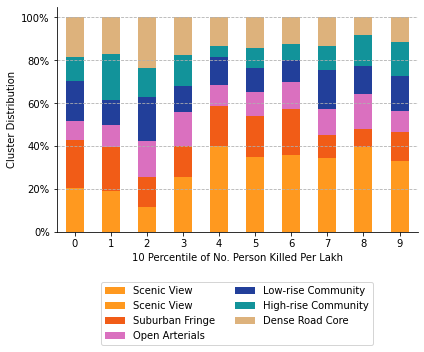

In [25]:
# plot a stacked horizontal barchart to show the distribution of cluster in each quintile
import matplotlib.pyplot as plt
import seaborn as sns

target = 'num_person_killed_per_lakh_city'
# target = 'gdp_per_cap_country_2022'
# target = 'mean_flux'
city_df_summary = generate_summary(target)

fig, ax = plt.subplots(figsize=(6,5))
city_df_summary[cluster_column_order].plot(kind='bar', 
                                  stacked=True, 
                                   color=[v for k,v in color_schema_update.items()],
                                  ax=ax)
sns.despine()
# move the legend to the bottom
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2,
           
           # relabel the legend
            labels=cluster_name_label,

           )
# y-axis label
plt.xlabel(f"10 Percentile of {label_cols[target]}")
# x-axis tick label horizontal
plt.xticks(rotation=0)
# x-axis label
# convert x-axis to percentage
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.ylabel("Cluster Distribution")

plt.grid(axis='y', linestyle='--')

plt.savefig(
    os.path.join(GRAPHIC_PATH, f"{target}_distribution{COMMENT}.svg"),
    dpi = 200,
            )

In [26]:

# sel_city = np.random.choice(city_df['City'], 30)
# city_df['City'].unique()

In [34]:
# visualize several cities
sel_city = {
    "Europe":{
    'Stockholm',
     'Munich',
     'Milan',
     'Madrid',
     'London', 
     'Moscow'
    },
     
    "Asia":{
    'Hong Kong', 
     'Singapore',
     'Tokyo',
     'Delhi',
     'Lima',
      'Bangkok',
      'Jakarta',
    },
    "Oceania":{
         'Sydney',
           'Wellington'
           },
           
    "North America":{ 
        'Montereal',
        'New York',
        'Boston', 
        'Denver',
        'Detroit',
        'Miami',
    },
      
    "South America":{
        'Guadalajara',
        'Santiago',
        'Buenos Aires',
        'Quito',
        'Santiago',
        'Valledupar'
    },
    
    "Africa":{        
            'Johannesburg',
            'Gaborone',
            'Accra',
            'Capetown',
            'Nairobi',
            'Belgrade',
    }
}
sel_city_ls = [x for y in sel_city.values() for x in y]

print(len(sel_city_ls))
city_abbr_ls = [x.lower().replace(" ", "") for x in sel_city_ls]
city_df['City'] = city_df['City'].apply(lambda x: x.title().strip())


sel_df = city_df[city_df['City'].isin(sel_city_ls)].reset_index(drop = True)
sel_df['Continent'] = sel_df['City'].apply(lambda x: [k for k,v in sel_city.items() if x in v][0])

sel_df = sel_df.sort_values(['Continent','num_person_killed_per_lakh_city'], ascending = True).reset_index(drop = True)

sel_df = sel_df.set_index('City')[cluster_column_order].drop_duplicates()
sel_df
# sel_df

32


,cluster_6,cluster_2,cluster_3,cluster_0,cluster_5,cluster_1,cluster_4
City,,,,,,,
Belgrade,0.271709,0.146779,0.233053,0.138375,0.094678,0.025210,0.090196
Accra,0.278507,0.046922,0.093845,0.336024,0.125631,0.025732,0.093340
Capetown,0.176054,0.073002,0.156702,0.492920,0.027218,0.009597,0.064506
Johannesburg,0.122745,0.120446,0.335364,0.277554,0.067349,0.009769,0.066774
Nairobi,0.368351,0.221487,0.027256,0.174914,0.152686,0.030167,0.025139
Hong Kong,0.090083,0.327813,0.104423,0.091295,0.188649,0.105231,0.092507
Singapore,0.004401,0.173699,0.232721,0.050479,0.332643,0.018121,0.187937
Tokyo,0.004958,0.014742,0.019961,0.072929,0.051533,0.754468,0.081409
Delhi,0.134984,0.165067,0.026712,0.060555,0.323262,0.259077,0.030342


C:\Users\yuanzfan\AppData\Local\Temp\ipykernel_30336\995397529.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


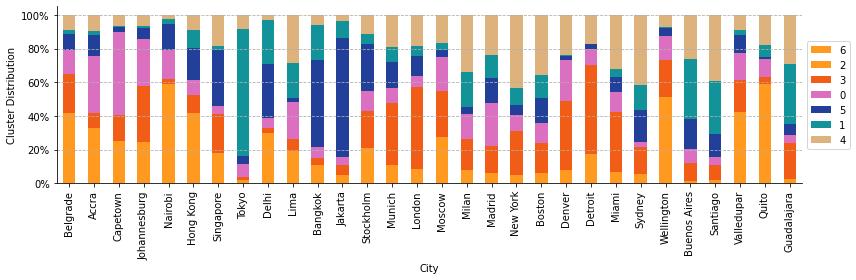

In [36]:
fig, ax = plt.subplots(figsize=(12,4))
sel_df.plot(kind='bar', 
                    stacked=True, 
                    color=[v for k,v in color_schema_update.items()],
                    ax=ax)
sns.despine()
# move the legend to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           # relabel the legend
            labels=cluster_order
           )
# y-axis label
# plt.xlabel(f"10 Percentile of {label_cols[target]}")
# x-axis label
# convert x-axis to percentage
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
# rotate 45 degree for the x-axis
plt.xticks(rotation=90)

plt.ylabel("Cluster Distribution")
# show main grids
plt.grid(axis='y', linestyle='--')

plt.savefig(
    os.path.join(GRAPHIC_PATH, f"cluster_distribution_selected_city{COMMENT}.svg"),
    dpi = 200,
    
            )

# 2. Select Sample Images from each hexagons to visualize the images from different cities but falling into same clusters

In [108]:
IMG_SAMPLE_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_analysis/img_sample"
if not os.path.exists(IMG_SAMPLE_FOLDER):
    os.makedirs(IMG_SAMPLE_FOLDER)

In [ ]:
# For each cluster,
# 1. sample 50 images within each 8 clusters' hexagon from these cities 
# ['New York','Singapore', 'Hong Kong', 'London','Bangkok','Nairobi']
# 2. for each 50 images, compute the proportion of the features
# 3. calculate the distance between the images and the cluster mean
# 4. find the images that are closest to the cluster mean from each city


ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
CURATED_FOLDER = "{ROOTFOLDER}/_curated"

CURATED_TARGET = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_hex"

META_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv"
GSV_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"

H3_RES = [9]

feature_ls = [ 'bike', 'building', 'bus', 'car',
       'grass', 'ground', 'house', 'installation', 'lake+waterboday', 'light',
       'mountain+hill', 'person', 'pole', 'railing', 'road',
       'shrub', 'sidewalk', 'signage', 'sky', 'skyscraper', 'sportsfield',
       'table+chair', 'tower', 'traffic light', 'trashcan', 'tree', 'truck',
       'van', 'wall', 'window']
DATA_FOLDER = "/lustre1/g/geog_pyloo/05_timemachine/_curated/c_seg_hex"
hex_detail = pd.read_parquet(os.path.join(DATA_FOLDER, "c_seg_cat=31_res=9.parquet"))
hex_detail_cluster = hex_detail.merge(hex_df[['hex_id', 'cluster_8']], on = 'hex_id')
hex_detail_cluster.shape[0], hex_detail.shape[0]
# find the cluster mean and find sample images that are close to the sample mean
cluster_mean = hex_detail_cluster[feature_ls+['cluster_8']].groupby('cluster_8').mean().reset_index()
cluster_mean

In [ ]:

def get_std(df_seg_update, variables_remain):
    scaler = StandardScaler().fit(df_seg_update[variables_remain])
    data = scaler.transform(df_seg_update[variables_remain])
    return data


def get_tsne(data, n_components=2):

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data
def load_class():
    serviceaccount = "../../google_drive_personal.json"
    import gspread

    # from oauth2client.service_account import ServiceAccountCredentials
    gc = gspread.service_account(filename=serviceaccount)

    def read_url(url, SHEET_NAME):
        SHEET_ID = url.split("/")[5]
        spreadsheet = gc.open_by_key(SHEET_ID)
        worksheet = spreadsheet.worksheet(SHEET_NAME)
        rows = worksheet.get_all_records()
        df_spread = pd.DataFrame(rows)
        return df_spread, worksheet

    url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
    SHEETNAME = "object150"
    obj_meta, other_worksheet = read_url(url, SHEETNAME)
    return obj_meta

def get_result(cityabbr, curated_folder, f_suffixes = "*panoptic.csv"):
    outfolder = f"{curated_folder}/{cityabbr}"
    seg_file = glob(os.path.join(outfolder, f_suffixes))
    panoptic_df = []
    for p in seg_file:
        temp = pd.read_csv(p)
        panoptic_df.append(temp)
    panoptic_df = pd.concat(panoptic_df).reset_index(drop = True)
    return panoptic_df

def clean_seg(seg_df, pano_df, meta_df):

    seg_df_filtered = seg_df.merge(meta_df, on = 'img')
    seg_df_filtered = seg_df_filtered[seg_df_filtered['size']>=10000].reset_index(drop = True)
    print("Segmentation shape after filter: ", seg_df_filtered.shape[0])
    seg_df_summary = seg_df_filtered.groupby(["img", "labels"]).agg({'areas':'sum'}).reset_index()
    seg_df_summary['panoid'] = seg_df_summary['img'].apply(lambda x: x[:22])

    col_cols = ["labels"]
    index_cols = ["img", "year", "h3_9"]
    seg_df_summary_pano = seg_df_summary.merge(pano_df, on = ['panoid'])
    
    
    if seg_df_summary_pano.shape[0]<seg_df_summary.shape[0]:
        print("data missing after data join.")
        print("Before join: ", seg_df_summary.shape[0])
        print("After join: ",seg_df_summary_pano.shape[0])
    else:
        print("data consistent")
    
    seg_df_summary = seg_df_summary_pano.drop_duplicates(index_cols+col_cols)
    print("Segmentation shape: ", seg_df_summary.shape[0])
    seg_df_pivot = seg_df_summary.pivot(
        columns = col_cols,
        index = index_cols,
        values = "areas"
    ).reset_index().fillna(0)
    return seg_df_pivot


In [126]:

def load_raw(city):
    cityabbr = city.lower().replace(" ", "")
    curate_folder = CURATED_FOLDER.format(ROOTFOLDER = ROOTFOLDER)

    seg_df = get_result(cityabbr, CURATED_FOLDER, f_suffixes = "*seg.csv")
    
    pano_df = pd.read_csv(PANO_PATH.format(
    ROOTFOLDER = ROOTFOLDER,
    cityabbr = cityabbr
    ))[['panoid', 'lat', 'lon', 'year', 'month']]

    for res in [9]:
        pano_df[f'h3_{res}'] = pano_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, res), axis=1)
        
    meta_df = pd.read_csv(META_PATH.format(
        ROOTFOLDER = ROOTFOLDER,
        cityabbr = cityabbr
    ))
    meta_df['img']= meta_df['path'].apply(lambda x: x.split("/")[-1].split(".")[0])
    # here make sure 
    meta_df = meta_df[['img','size','path']]
    return seg_df, meta_df, pano_df

def get_seg_data(city):
    seg_df, meta_df, pano_df = load_raw(city)
    seg_df_pivot = clean_seg(seg_df, pano_df, meta_df)
    print(f"city {cityabbr} saved")
    print("*"*50)

    hex_detail_cluster_city_sel = hex_detail_cluster[hex_detail_cluster['city_lower']==cityabbr]\
        .groupby('cluster_8').apply(lambda x: x.sample(10)).reset_index(drop = True)
    # seg_df_pivot_sel = seg_df_pivot[seg_df_pivot['h3_9'].isin(hex_detail_cluster_city_sel['hex_id'])]
    seg_df_pivot_sel = seg_df_pivot.merge(hex_detail_cluster_city_sel[['hex_id', 'cluster_8']], left_on = 'h3_9', right_on = 'hex_id')\
        .drop('hex_id', axis = 1)
        
    obj_meta = load_class()
    obj_meta["id"] = obj_meta["id"].astype(str)
    ADE_CATEGORIES_DICT = dict(zip(obj_meta["id"].values, obj_meta["category"].values))
    new_cols = []
    for x in seg_df_pivot_sel.columns:
        if str(x) in obj_meta["id"].values:
            new_cols.append(ADE_CATEGORIES_DICT[str(x)])
        else:
            new_cols.append(str(x))
    seg_df_pivot_sel.columns = new_cols

    # drop the columns if all value are 0
    variables = set([v for v in seg_df_pivot_sel.columns if v in obj_meta["category"].unique()])
    print("Variables original: ", len(variables))
    to_drop = ["other"]
    variables_remain = [v for v in variables if not v in to_drop]
    print("Variables kept: ", len(variables_remain))
    seg_df_pivot_sel_stack = seg_df_pivot_sel.set_index(["img", "year", "h3_9","cluster_8"]).stack().reset_index().fillna(0)\
        .groupby(["img", "year", "h3_9","cluster_8","level_4"]).sum().reset_index()\
            .pivot_table(index = ["img", "year", "h3_9","cluster_8"], columns = "level_4", values = 0).reset_index().fillna(0)\
                .drop(columns = ['other'], axis = 1)
    return seg_df_pivot_sel_stack, meta_df

def sel_cluster_sample(city, cluster_mean, seg_df_i, meta_df,cluster_i):
    cityabbr = city.lower().replace(" ", "")
    cluster_mean_i = cluster_mean[feature_ls].iloc[cluster_i].values
    seg_df_i = seg_df_pivot_sel_stack[seg_df_pivot_sel_stack['cluster_8']==cluster_i]\
        .set_index(['img']).drop(['cluster_8','year', 'h3_9'], axis = 1)
    seg_df_i['distance_to_mean'] = np.linalg.norm(seg_df_i[feature_ls].values - cluster_mean_i, axis = 1)
    seg_df_i_sel = seg_df_i.sort_values('distance_to_mean').head(10)
    imgsel = seg_df_i_sel.index
    # find the path of these images
    export_folder = os.path.join(IMG_SAMPLE_FOLDER, 'cluster_'+str(cluster_i), cityabbr)
    if not os.path.exists(export_folder):
        os.makedirs(export_folder)
    gsv_df_sel = meta_df[meta_df['img'].isin(imgsel)].reset_index(drop = True)
    import shutil
    from tqdm import tqdm
    for i, row in tqdm(gsv_df_sel.iterrows()):
        shutil.copy(row['path'], os.path.join(export_folder, row['img']+".jpg"))

In [ ]:
# compute the distance between each image to the cluster_mean


for i in range(1, 8):
    sel_cluster_sample(i)

10it [00:01,  8.35it/s]
10it [00:01,  8.16it/s]
10it [00:01,  8.39it/s]
10it [00:01,  9.37it/s]
10it [00:00, 10.30it/s]
10it [00:00, 10.20it/s]
10it [00:01,  8.45it/s]


In [119]:
export_folder

'/lustre1/g/geog_pyloo/05_timemachine/_curated/c_analysis/img_sample/cluster_0/newyork'

In [118]:
os.listdir(export_folder)

['jZxOFXxSKEJkgFukpHLkYg_270.jpg',
 'UnZv77uS4nNYS_RMzVftKQ_0.jpg',
 'ZIP8PmpAegxmpiZ4CsW-BQ_270.jpg',
 'C4U2LrvtQPDIApVbEB9UxA_90.jpg',
 'V4EZWJHvQH9x9FerNUYtwQ_90.jpg',
 'Xou24XL39beqLW4yBfD93g_270.jpg',
 'V4EZWJHvQH9x9FerNUYtwQ_0.jpg',
 'hoJ7U4LYSBJY-DiyuIBDow_270.jpg',
 'xSkrHacdDZUTHHrKuap3ew_270.jpg',
 'yEjLoCJiM6JD7bTfhPDPVg_270.jpg']

In [130]:
gsv_df['path'].values

array(['/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/newyork/img_rgb/7_1/6/a/EfR4fIXxYq6JetwCAn05Dw_0.jpg',
       '/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/newyork/img_rgb/7_1/6/a/EfR4fIXxYq6JetwCAn05Dw_90.jpg',
       '/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/newyork/img_rgb/7_1/6/a/EfR4fIXxYq6JetwCAn05Dw_180.jpg',
       ...,
       '/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/newyork/img_rgb/7_1/5/6/eq9W1atCpfrvGWyUHa9oPg_90.jpg',
       '/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/newyork/img_rgb/7_1/5/6/eq9W1atCpfrvGWyUHa9oPg_180.jpg',
       '/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/newyork/img_rgb/7_1/5/6/eq9W1atCpfrvGWyUHa9oPg_270.jpg'],
      dtype=object)

In [143]:
test_img = 'l4LhrAxqHZH7xOEo_FXlXg_90'
path = gsv_df[gsv_df['img']==test_img]['path'].values[0]
path

'/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/newyork/img_rgb/f_1/b/4/l4LhrAxqHZH7xOEo_FXlXg_90.jpg'

In [144]:
# seg_df_pivot_sel_stack[seg_df_pivot_sel_stack['img']==test_img]
seg_df[seg_df['img']==test_img]

,labels,areas,img
1358677,0,29720,l4LhrAxqHZH7xOEo_FXlXg_90
1358678,3,31533,l4LhrAxqHZH7xOEo_FXlXg_90
1358679,5,73923,l4LhrAxqHZH7xOEo_FXlXg_90
1358680,20,24824,l4LhrAxqHZH7xOEo_FXlXg_90


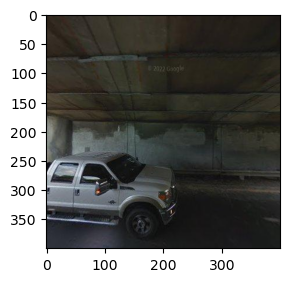

In [145]:
# show this image
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open(path)
plt.imshow(img)